# Solver tolerances


In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import time

Note: you may need to restart the kernel to use updated packages.



The goal of each solver is the solve the problem as fast as possible while maintaining a certain level of accuracy. The accuracy is controlled by the tolerances, one for the relative residual and one for the absolute residual.

At each iteration, the solver computes an estimate of the current error $\mathbf{e_k} = \mathbf{y_k} - \mathbf{y}$, where $\mathbf{y_k}$ is the current approximation and $\mathbf{y}$ is the exact solution. It accepts the current approximation if the error is small enough according to the set relative tolerance $\epsilon_r$ and absolute tolerance $\epsilon_a$, using the following criteria:

$$
\frac{1}{n} \sum_{i=1}^n \frac{|e_{k,i}|}{\epsilon_r |y_i| + \epsilon_a} \leq 1
$$

The relative tolerance is used to control the error relative to the current magnitude of the solution, while the absolute tolerance is used to control the error in absolute terms (i.e. when the solution is close to zero). Note that these errors are computed in relation to the solution for the state variables of the equations, and not the output variables that might be computed by PyBaMM after the solution is found.

## Default tolerances

The default tolerances for the solvers are always given in the documentation of each solver. For example, the default tolerances for the IDAKLU solver can be seen [here](https://docs.pybamm.org/en/stable/source/api/solvers/idaklu_solver.html) as the default values for the `rtol` and `atol` arguments to the solver `__init__` method.

## Setting tolerances

Generally, a smaller value for the tolerances will lead to a more accurate solution, but will also require more computational effort. For examples, here are the timings for the default SPM and DFN models with different tolerances ranging from $10^{-2}$ to $10^{-6}$:

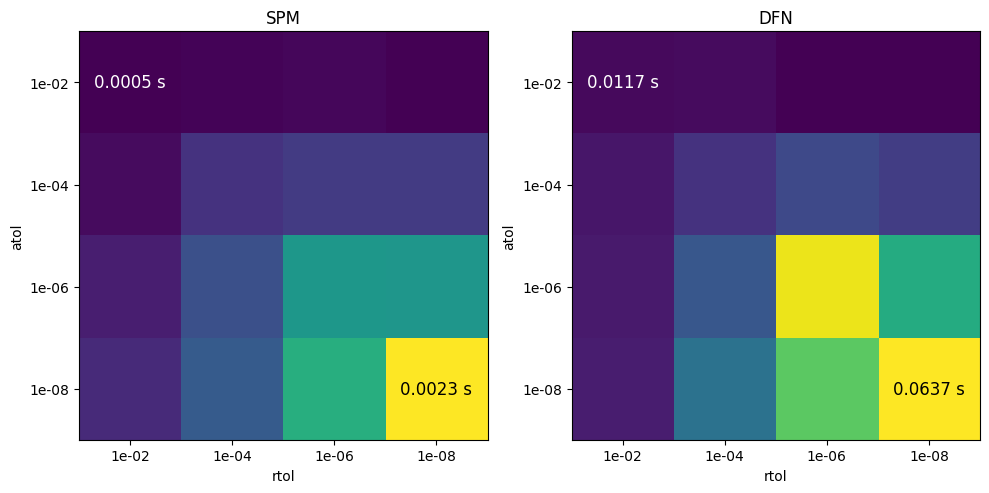

In [2]:
# time how long it takes to solve the model with different tolerances
models = [pybamm.lithium_ion.SPM(), pybamm.lithium_ion.DFN()]
model_names = ["SPM", "DFN"]
atols = [1e-2, 1e-4, 1e-6, 1e-8]
rtols = [1e-2, 1e-4, 1e-6, 1e-8]
results = np.zeros((len(models), len(atols), len(rtols)))
for imodel, model in enumerate(models):
    for iatol, atol in enumerate(atols):
        for irtol, rtol in enumerate(rtols):
            solver = pybamm.IDAKLUSolver(atol=atol, rtol=rtol)
            sim = pybamm.Simulation(model, solver=solver)
            sol = sim.solve([0, 3600])
            start_time = time.perf_counter()
            sol = sim.solve([0, 3600])
            end_time = time.perf_counter()
            results[imodel, iatol, irtol] = end_time - start_time

# plot results in a separate plot for each model
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for imodel, _model in enumerate(models):
    ax[imodel].imshow(
        results[imodel],
        vmin=results[imodel].min(),
        vmax=results[imodel].max(),
        cmap="viridis",
    )
    ax[imodel].set_xticks(range(len(rtols)))
    ax[imodel].set_xticklabels([f"{rtol:.0e}" for rtol in rtols])
    ax[imodel].set_xlabel("rtol")
    ax[imodel].set_yticks(range(len(atols)))
    ax[imodel].set_yticklabels([f"{atol:.0e}" for atol in atols])
    ax[imodel].set_ylabel("atol")
    ax[imodel].set_title(model_names[imodel])
    ax[imodel].text(
        0,
        0,
        f"{results[imodel].min():.4f} s",
        ha="center",
        va="center",
        color="white",
        fontsize=12,
    )
    ax[imodel].text(
        3,
        3,
        f"{results[imodel].max():.4f} s",
        ha="center",
        va="center",
        color="black",
        fontsize=12,
    )

plt.tight_layout()
plt.show()

Thus, the choice of tolerances is a trade-off between accuracy and computational time. It can often be difficult to know what tolerances to use, but a good starting point is to use the default tolerances and then adjust them if the solver is too slow or too inaccurate. 

You can also use a convergence study to determine the best tolerances for your problem, using either an analytical solution (if available) or by comparing the solution to a high-tolerance solution. For example, lets compare the solution of a high-tolerance SPM model to a lower-tolerance SPM model while varying the tolerances. We'll pick some goal relative and absolute tolerances of $10^{-4}$ and $10^{-6}$ respectively and use a similar error norm as the solve. We'll then then vary the tolerances from $10^{-2}$ to $10^{-6}$ and see when the solution is within the set goal tolerances.

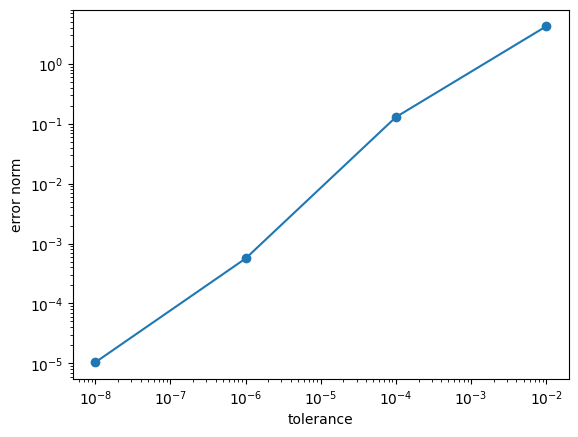

In [4]:
models = pybamm.lithium_ion.DFN()
high_tol = 1e-10
goal_rtol = 1e-4
goal_atol = 1e-6
t_eval = np.linspace(0, 3600, 100)
solver = pybamm.IDAKLUSolver(atol=high_tol, rtol=high_tol)
sim = pybamm.Simulation(models, solver=solver)
high_tol_sol = sim.solve([0, 3600])["Voltage [V]"](t_eval)

tols = [1e-2, 1e-4, 1e-6, 1e-8]
results = np.zeros(len(tols))
for itol, tol in enumerate(tols):
    solver = pybamm.IDAKLUSolver(atol=tol, rtol=tol)
    sim = pybamm.Simulation(model, solver=solver)
    sol = sim.solve([0, 3600])["Voltage [V]"](t_eval)
    results[itol] = np.sum(
        np.abs(sol - high_tol_sol) / (goal_rtol * np.abs(high_tol_sol) + goal_atol)
    ) / len(sol)

# plot results on a log scale
plt.figure()
plt.plot(tols, results, "o-")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("tolerance")
plt.ylabel("error norm")
plt.show()

This gives us some justification that a tolerance of $10^{-3}$ is a good compromise between accuracy and computational time for this problem. However, the choice of tolerances will be highly problem-dependent, and your measure of error may be different to the one used here, so it is always best to determine the appropriate error measure and convergence study for your particular problem.